In [1]:
!pip install keras-tuner
!pip install feature-engine
!pip install holidays

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 4.4 MB/s eta 0:00:00


In [2]:
# Comment out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM, TimeDistributed
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle


# For data processing
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# For data processing and manipulation
import pandas as pd

# For date calculations
import datetime

# For encoding the label(word to onehot)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# For spliting the dataset into Train, Validation and Test
from sklearn.model_selection import train_test_split

from scipy.stats import hmean

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold

# For evaluation metrices
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

# For SOM
#from minisom import MiniSom

# For ploting data
import itertools
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For checking path
import os
from os import path
import csv


Using TensorFlow backend


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


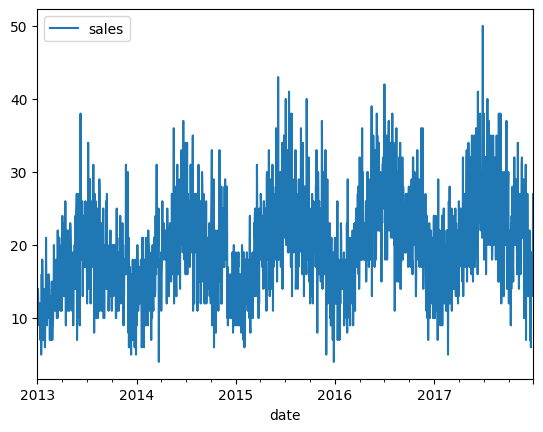

In [4]:
df = pd.read_excel("/content/drive/MyDrive/dataset.xlsx")
df.plot(x = 'date', y = 'sales')
plt.show()

In [5]:
df.shape

(1826, 3)

In [6]:
df.head()

,Unnamed: 0,date,sales
0,0,2013-01-01,13
1,1,2013-01-02,11
2,2,2013-01-03,14
3,3,2013-01-04,13
4,4,2013-01-05,10


In [7]:
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [8]:
df.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [9]:
import holidays
from datetime import date

bd_holidays = holidays.BD()

def is_holiday(date):
    # Ensure the date is in the correct format (date object)
    if isinstance(date, str):
        date = date.fromisoformat(date)
    return int(date in bd_holidays)

df['is_holiday'] = df['date'].apply(is_holiday)

In [10]:
df

,date,sales,is_holiday
0,2013-01-01,13,0
1,2013-01-02,11,0
2,2013-01-03,14,0
3,2013-01-04,13,0
4,2013-01-05,10,0
...,...,...,...
1821,2017-12-27,14,0
1822,2017-12-28,19,0
1823,2017-12-29,15,0
1824,2017-12-30,27,0


In [ ]:
# Process the Dates column
df['date'] = pd.to_datetime(df['date'])
from feature_engine.datetime import DatetimeFeatures
dtf = DatetimeFeatures(features_to_extract = ["year", "month", "day_of_month", "day_of_week"])
dtf.fit(df)
df = dtf.transform(df)

In [ ]:
df

,sales,is_holiday,date_year,date_month,date_day_of_month,date_day_of_week
0,13,0,2013,1,1,1
1,11,0,2013,1,2,2
2,14,0,2013,1,3,3
3,13,0,2013,1,4,4
4,10,0,2013,1,5,5
...,...,...,...,...,...,...
1821,14,0,2017,12,27,2
1822,19,0,2017,12,28,3
1823,15,0,2017,12,29,4
1824,27,0,2017,12,30,5


In [ ]:
from feature_engine.creation import CyclicalFeatures
cf = CyclicalFeatures()
cf.fit(df.iloc[:,3:])
df_cyclic = cf.transform(df.iloc[:,3:])

In [ ]:
df_cyclic

,date_month,date_day_of_month,date_day_of_week,date_month_sin,date_month_cos,date_day_of_month_sin,date_day_of_month_cos,date_day_of_week_sin,date_day_of_week_cos
0,1,1,1,5.000000e-01,0.866025,2.012985e-01,0.979530,8.660254e-01,0.5
1,1,2,2,5.000000e-01,0.866025,3.943559e-01,0.918958,8.660254e-01,-0.5
2,1,3,3,5.000000e-01,0.866025,5.712682e-01,0.820763,1.224647e-16,-1.0
3,1,4,4,5.000000e-01,0.866025,7.247928e-01,0.688967,-8.660254e-01,-0.5
4,1,5,5,5.000000e-01,0.866025,8.486443e-01,0.528964,-8.660254e-01,0.5
...,...,...,...,...,...,...,...,...,...
1821,12,27,2,-2.449294e-16,1.000000,-7.247928e-01,0.688967,8.660254e-01,-0.5
1822,12,28,3,-2.449294e-16,1.000000,-5.712682e-01,0.820763,1.224647e-16,-1.0
1823,12,29,4,-2.449294e-16,1.000000,-3.943559e-01,0.918958,-8.660254e-01,-0.5
1824,12,30,5,-2.449294e-16,1.000000,-2.012985e-01,0.979530,-8.660254e-01,0.5


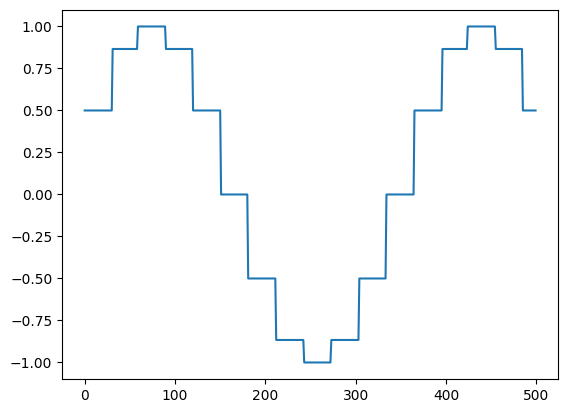

In [ ]:
plt.plot(df_cyclic.index[:500],df_cyclic["date_month_sin"][:500])

In [ ]:
starting_year = df['date_year'].min()
df['year_encoded'] = df['date_year'] - starting_year

In [ ]:
df_sales = pd.DataFrame(df['sales'])
from feature_engine.timeseries.forecasting import LagFeatures
lf = LagFeatures(periods=list(range(1,31)))
df_lag = lf.fit_transform(df_sales)
df_lag = df_lag.iloc[:, ::-1]

In [ ]:
print(df.columns)
print(df_cyclic.columns)
print(df_lag.columns)

Index(['sales', 'is_holiday', 'date_year', 'date_month', 'date_day_of_month',
       'date_day_of_week', 'year_encoded'],
      dtype='object')
Index(['date_month', 'date_day_of_month', 'date_day_of_week', 'date_month_sin',
       'date_month_cos', 'date_day_of_month_sin', 'date_day_of_month_cos',
       'date_day_of_week_sin', 'date_day_of_week_cos'],
      dtype='object')
Index(['sales_lag_30', 'sales_lag_29', 'sales_lag_28', 'sales_lag_27',
       'sales_lag_26', 'sales_lag_25', 'sales_lag_24', 'sales_lag_23',
       'sales_lag_22', 'sales_lag_21', 'sales_lag_20', 'sales_lag_19',
       'sales_lag_18', 'sales_lag_17', 'sales_lag_16', 'sales_lag_15',
       'sales_lag_14', 'sales_lag_13', 'sales_lag_12', 'sales_lag_11',
       'sales_lag_10', 'sales_lag_9', 'sales_lag_8', 'sales_lag_7',
       'sales_lag_6', 'sales_lag_5', 'sales_lag_4', 'sales_lag_3',
       'sales_lag_2', 'sales_lag_1', 'sales'],
      dtype='object')


In [ ]:
features = pd.concat([df.loc[:,['is_holiday','year_encoded']],
                     df_cyclic.loc[:,['date_month_sin','date_month_cos', 'date_day_of_month_sin', 'date_day_of_month_cos', 'date_day_of_week_sin', 'date_day_of_week_cos']],
                     df_lag.iloc[:,:-1]], axis=1
                     )

In [ ]:
target = df['sales']

In [ ]:
type(target)

pandas.core.series.Series

In [ ]:
df_final = pd.concat([features, target], axis=1)

In [ ]:
df_final.to_csv('output.csv', index=False)  # Specify the file name and set index to False if you don't want to save the index

In [ ]:




earsonCorr = df_final.corrwith(df_final['sales'])
pearsonCorr

is_holiday              -0.026079
year_encoded             0.297981
date_month_sin          -0.265298
date_month_cos          -0.455306
date_day_of_month_sin   -0.027442
date_day_of_month_cos   -0.002131
date_day_of_week_sin    -0.197102
date_day_of_week_cos     0.018328
sales_lag_1              0.447695
sales_lag_2              0.365911
sales_lag_3              0.345252
sales_lag_4              0.352220
sales_lag_5              0.372945
sales_lag_6              0.427353
sales_lag_7              0.570804
sales_lag_8              0.415314
sales_lag_9              0.354364
sales_lag_10             0.336003
sales_lag_11             0.318497
sales_lag_12             0.343785
sales_lag_13             0.409165
sales_lag_14             0.552989
sales_lag_15             0.405731
sales_lag_16             0.333335
sales_lag_17             0.301782
sales_lag_18             0.314908
sales_lag_19             0.332456
sales_lag_20             0.396083
sales_lag_21             0.515494
sales_lag_22  

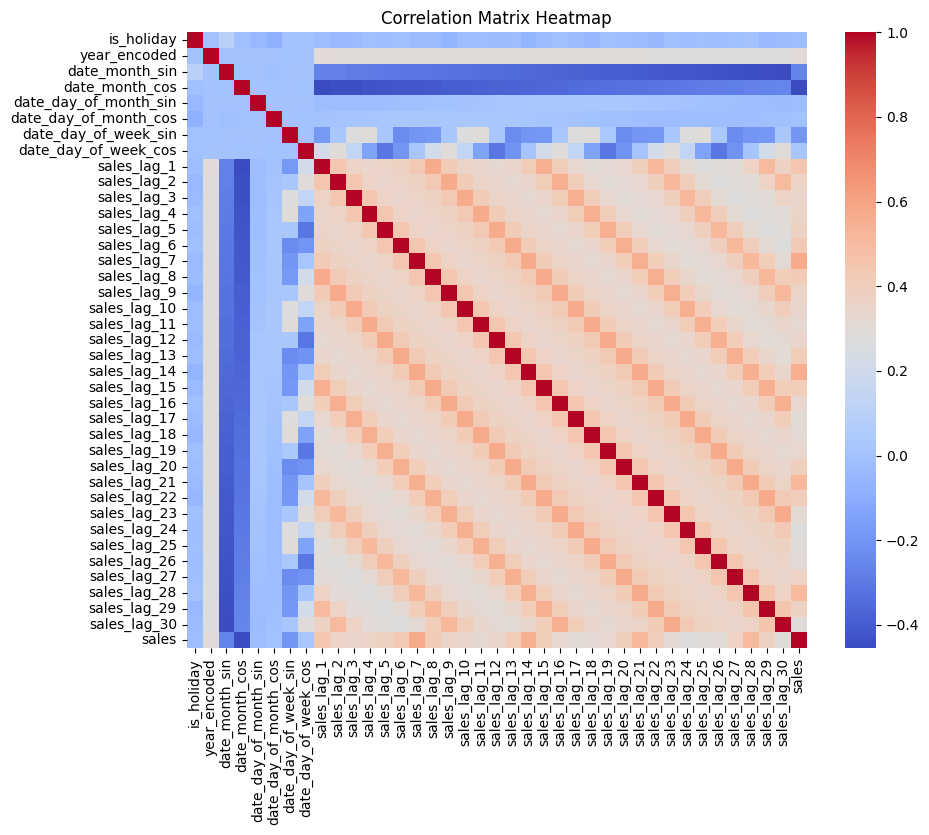

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'df' containing your data
correlation_matrix = df_final.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")

plt.show()


In [ ]:
correlation_matrix.to_csv("correlation_matrix.csv",index=False)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming df_final contains your independent variables
X = add_constant(df_final.iloc[31:,:-1])
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

In [ ]:
vif

const                    108.443110
is_holiday                 1.036947
year_encoded               2.387349
date_month_sin             3.391886
date_month_cos             3.252109
date_day_of_month_sin      1.021127
date_day_of_month_cos      1.023599
date_day_of_week_sin       3.354187
date_day_of_week_cos       3.759428
sales_lag_1                2.003560
sales_lag_2                2.015753
sales_lag_3                2.014317
sales_lag_4                2.045309
sales_lag_5                2.042772
sales_lag_6                2.057622
sales_lag_7                1.929212
sales_lag_8                2.051459
sales_lag_9                2.068917
sales_lag_10               2.070862
sales_lag_11               2.103754
sales_lag_12               2.094046
sales_lag_13               2.097710
sales_lag_14               1.991971
sales_lag_15               2.091407
sales_lag_16               2.109132
sales_lag_17               2.092724
sales_lag_18               2.110106
sales_lag_19               2